# Application with new data

This tutorial demonstrates how to spatial data alignment on new MERFISH and STARmap mouse visual cortex data using SODB and STAGATE based on pyG (PyTorch Geometric) framework.

A reference paper can be found at https://www.nature.com/articles/s41467-022-29439-6.

This tutorial refers to the following tutorial at https://stagate.readthedocs.io/en/latest/AT2.html. At the same time, the way of loadding data is modified by using SODB.

## Import packages and set configurations

In [ ]:
# Use the Python warnings module to filter and ignore any warnings that may occur in the program after this point
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Import several Python packages commonly used in data analysis and visualization:
# pandas (imported as pd) is a package for data manipulation and analysis
import pandas as pd
# numpy (imported as np) is a package for numerical computing with arrays
import numpy as np
# scanpy (imported as sc) is a package for single-cell RNA sequencing analysis
import scanpy as sc
# matplotlib.pyplot (imported as plt) is a package for data visualization
import matplotlib.pyplot as plt
# os is a package for interacting with the operating system, such as reading or writing files
import os
# sys is a package for interacting with the Python interpreter
import sys
# Seaborn is a package for statistical data visualization
import seaborn as sns
# gc is a module for garbage collection in Python
import gc

In [ ]:
# Import a STAGATE_pyG package
import STAGATE_pyG as STAGATE

In [3]:
# Imports a palettable package
import palettable
# Create two variables with lists of colors for categorical visualizations and biotechnology-related visualizations, respectively.
cmp_new = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
cmp_new_biotech = palettable.cartocolors.qualitative.Safe_4.mpl_colors

## Streamline development of loading spatial data with SOBD

In [ ]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [ ]:
# Initialization
sodb = pysodb.SODB()

In [4]:
# Load new MERFISH and STARmap mouse visual cortex data

adata_merfish = sodb.load_experiment('Merfish_Visp','mouse_VISp')
adata_STARmap = sodb.load_experiment('Wang2018Three_1k','mouse_brain_STARmap')

adata_merfish.obs['Tech'] = 'MERFISH'
adata_STARmap.obs['Tech'] = 'STARmap'

load experiment[mouse_VISp] in dataset[Merfish_Visp]
load experiment[mouse_brain_STARmap] in dataset[Wang2018Three_1k]


In [5]:
adata_list = {
    'MERFISH':adata_merfish,
    'STARmap':adata_STARmap
}

## Constructing the spatial network for each secion

------Calculating spatial graph...
The graph contains 19162 edges, 2399 cells.
7.9875 neighbors per cell on average.


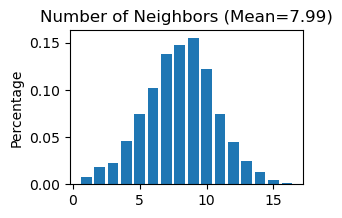

In [7]:
# Use "STAGATE_pyG.Cal_Spatial_Net" to calculate a spatial graph with a radius cutoff of 50 for adata_list['MERFISH']
STAGATE.Cal_Spatial_Net(adata_list['MERFISH'], rad_cutoff=50)
# Use "STAGATE_pyG.Stats_Spatial_Net" to summarize cells and edges information for adata_list['MERFISH']
STAGATE.Stats_Spatial_Net(adata_list['MERFISH'])

------Calculating spatial graph...
The graph contains 6990 edges, 930 cells.
7.5161 neighbors per cell on average.


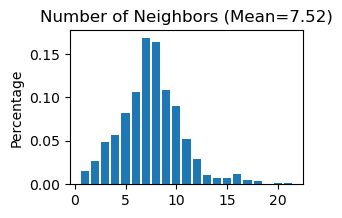

In [8]:
# Use "STAGATE_pyG.Cal_Spatial_Net" to calculate a spatial graph with a radius cutoff of 50 for adata_list['STARmap']
STAGATE.Cal_Spatial_Net(adata_list['STARmap'], rad_cutoff=400)
# Use "STAGATE_pyG.Stats_Spatial_Net" to summarize cells and edges information for adata_list['STARmap']
STAGATE.Stats_Spatial_Net(adata_list['STARmap'])

In [ ]:
# Concatenate 'MERFISH' and 'STARmap' into a single AnnData object named 'adata'
adata = sc.concat([adata_list['MERFISH'], adata_list['STARmap']], keys=None)

In [ ]:
# Concatenate two 'Spatial_Net'
adata.uns['Spatial_Net'] = pd.concat([adata_list['MERFISH'].uns['Spatial_Net'], adata_list['STARmap'].uns['Spatial_Net']])

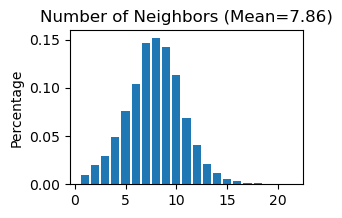

In [9]:
# Use "STAGATE_pyG.Stats_Spatial_Net" to summarize cells and edges information for whole adata
STAGATE.Stats_Spatial_Net(adata)

In [10]:
# Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [11]:
adata

AnnData object with n_obs × n_vars = 3329 × 102
    obs: 'leiden', 'Tech'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial'

## Running STAGATE

In [12]:
adata = STAGATE.train_STAGATE(adata, n_epochs=500)

Size of Input:  (3329, 102)


100%|██████████| 500/500 [00:02<00:00, 173.63it/s]


In [13]:
# Calculate the nearest neighbors in the 'STAGATE' representation and compute the UMAP embedding.
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

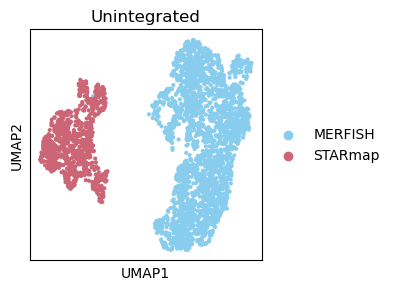

In [16]:
# Plot a UMAP projection
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='Tech', title='Unintegrated',show=False,palette=cmp_new_biotech)
plt.savefig('figures/new_before_umap.png',dpi=400,transparent=True,bbox_inches='tight')
plt.savefig('figures/new_before_umap.pdf',dpi=400,transparent=True,bbox_inches='tight')

In [17]:
# Use louvain to cluster cells
sc.tl.louvain(adata,resolution=0.5)

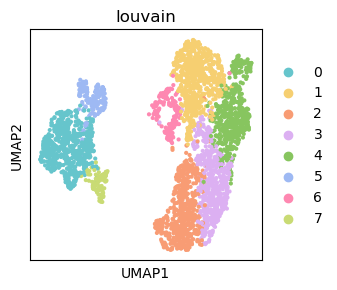

In [19]:
# Generate a plot of the UMAP embedding colored by louvain
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color='louvain',show=False,palette=cmp_new)
plt.savefig('figures/new_before_umap_leiden.png',dpi=400,transparent=True,bbox_inches='tight')
plt.savefig('figures/new_before_umap_leiden.pdf',dpi=400,transparent=True,bbox_inches='tight')

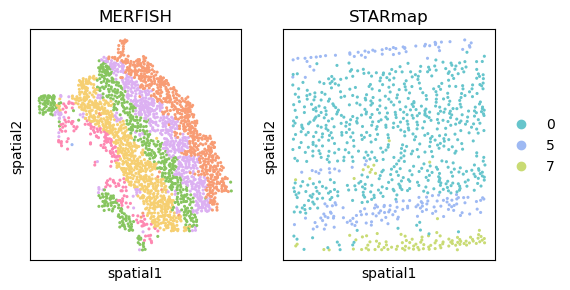

In [21]:
# Display spatial distribution of cells colored by Louvain clustering for two sequencing technologies ('MERFISH' and 'STARmap')
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
it=0
for temp_tech in ['MERFISH', 'STARmap']:
    temp_adata = adata[adata.obs['Tech']==temp_tech, ]
    if it == 1:
        sc.pl.embedding(temp_adata, basis="spatial", color="louvain",s=20, ax=axs[it],
                        show=False, title=temp_tech)
    else:
        sc.pl.embedding(temp_adata, basis="spatial", color="louvain",s=20, ax=axs[it], legend_loc=None,
                        show=False, title=temp_tech)
    it+=1
plt.savefig('figures/new_before_spatial_leiden0.5.png',dpi=400,transparent=True,bbox_inches='tight')
plt.savefig('figures/new_before_spatial_leiden0.5.pdf',dpi=400,transparent=True,bbox_inches='tight')

## Perform Harmony for spatial data intergration

Harmony is an algorithm for integrating multiple high-dimensional datasets
It can be employed as a reference at https://github.com/slowkow/harmonypy and https://pypi.org/project/harmonypy/

In [22]:
# Import harmonypy package
import harmonypy as hm

In [23]:
# Use STAGATE representation to create 'meta_data' for harmony
data_mat = adata.obsm['STAGATE'].copy()
meta_data = adata.obs.copy()

In [25]:
# Run harmony for STAGATE representation
ho = hm.run_harmony(data_mat, meta_data, ['Tech'])

2023-03-21 13:33:25,806 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-03-21 13:33:27,207 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-03-21 13:33:27,227 - harmonypy - INFO - Iteration 1 of 10
2023-03-21 13:33:27,675 - harmonypy - INFO - Iteration 2 of 10
2023-03-21 13:33:28,125 - harmonypy - INFO - Iteration 3 of 10
2023-03-21 13:33:28,594 - harmonypy - INFO - Iteration 4 of 10
2023-03-21 13:33:28,994 - harmonypy - INFO - Converged after 4 iterations


In [26]:
# Write the adjusted PCs to a new file.
res = pd.DataFrame(ho.Z_corr)
res.columns = adata.obs_names

In [27]:
# Create a new AnnData object adata_Harmony using a transpose of the res matrix
adata_Harmony = sc.AnnData(res.T)

In [28]:
adata_Harmony.obsm['spatial'] = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names).loc[adata_Harmony.obs_names,].values
adata_Harmony.obs['Tech'] = adata.obs.loc[adata_Harmony.obs_names, 'Tech']

## Spatial Clustering after integration

In [29]:
# Calculate the nearest neighbors in the corrected representation and computes the UMAP embedding.
sc.pp.neighbors(adata_Harmony)
sc.tl.umap(adata_Harmony)

In [30]:
# Use leiden to cluster after integration
sc.tl.leiden(adata_Harmony, resolution=0.3)

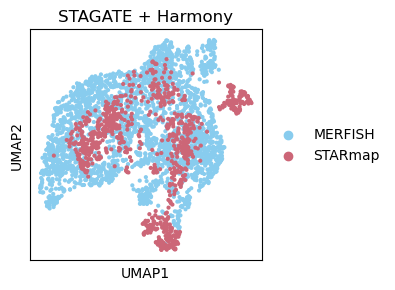

In [31]:
# Plot a UMAP embedding colored by leiden after integration
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_Harmony, color='Tech', title='STAGATE + Harmony',show=False,palette=cmp_new_biotech)
plt.savefig('figures/new_after_umap.png',dpi=400,transparent=True,bbox_inches='tight')
plt.savefig('figures/new_after_umap.pdf',dpi=400,transparent=True,bbox_inches='tight')

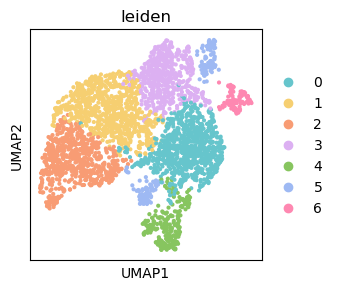

In [32]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_Harmony, color='leiden',show=False,palette=cmp_new)
plt.savefig('figures/new_after_umap_leiden0.3.png',dpi=400,transparent=True,bbox_inches='tight')
plt.savefig('figures/new_after_umap_leiden0.3.pdf',dpi=400,transparent=True,bbox_inches='tight')

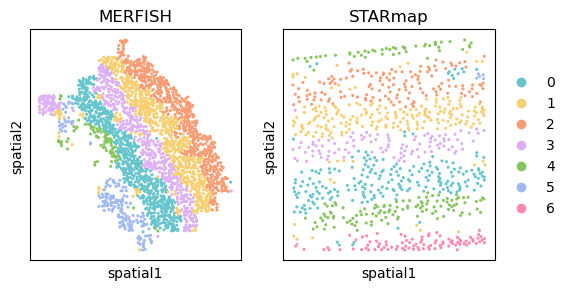

In [33]:
# Display spatial distribution of cells colored by leiden clustering for two sequencing technologies ('MERFISH' and 'STARmap') after integration
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
it=0
for temp_tech in ['MERFISH', 'STARmap']:
    temp_adata = adata_Harmony[adata_Harmony.obs['Tech']==temp_tech, ]
    if it == 1:
        sc.pl.embedding(temp_adata, basis="spatial", color="leiden",s=20, ax=axs[it],
                        show=False, title=temp_tech)
    else:
        sc.pl.embedding(temp_adata, basis="spatial", color="leiden",s=20, ax=axs[it], legend_loc=None,
                        show=False, title=temp_tech)
    it+=1
plt.savefig('figures/new_after_spatial_leiden0.3.png',dpi=400,transparent=True,bbox_inches='tight')
plt.savefig('figures/new_after_spatial_leiden0.3.pdf',dpi=400,transparent=True,bbox_inches='tight')